# SIMULATION VALIDATION: SCOPE OVERVIEW

In this notebook we present an example of performing simulation validation. On this notebook, we will be validating the Lunar Lander sample.

### Sim Validation Fronts
- **Bonsai-readiness**: This front aims to identify any missing pieces towards training a Bonsai brain with the simulation.
- **Sim2Real gap**: This front aims to discover any discrepancies between the simulated and the deployment environment.
    - Ideally, we want the simulation to be an exact copy of the deployment 'real' environment.
    - Tests to evaluate the sim2real gap can be performed looking at the historical data available with the control.

### Sim Validation Tests
- _BONSAI-READINESS_
    - **Verify Bonsai Training Compatibility**: START, STEP, and RESET methods
        - START method: A function exists to start the simulation.
        - STEP method: A function exists that takes an action, and applies it to the simulation.
        - RESET method: A function exists that takes a configuration dictionary, and re-starts the simulation to initial conditions.
        - STATE method: A function exists that retrieves the current status of the simulation.
    - **Test Simulation Speed**: Simulation speed must be faster than 0.1 s/it towards having manageable experimentation times.
- _SIM2REAL GAP_
    - **Test Initialization Conditions**: The initial conditions across episodes are expected and valid for our training.
        - The simulation should present the brain with all the initial conditions that it may encounter once deployed. Talk with the Subject Matter Experts (SMEs) to verify that your simulation is exposing the right state space to the brain.
    - **Test Config Parameters**: The configuration parameters work as expected.
        - The configuration might permit defining the initial conditions, or modifying the behavior of the simulation when needed. Test each parameter, and evaluate they work as expected.
    - **Test Simulation Behavior**: The response of the simulation to programmed actions works as expected.
        - Once the initial conditions are understood, and agreed upon with SMEs, you want to validate that the response of the simulation to specific control sequences is the one expected.
    - **Test Baseline Control**: The response of the simulation to the baseline control works AND performs as expected.
        - If we are able to connect the expert control to the simulation, we can validate both the resulting states as well as the KPI performance metric. If either of these diverges from the expectations SMEs have, we have identify a clear performance gap.


**In this notebook, we avoid diving deep into the following 2 aspects of sim validation:**
- Verify Bonsai Training Compatibility:
    - For simplicity, we assume the test has already been validated with the simulation engineers. ***(see sim specs bellow)***
- Test Baseline Control:
    - For this demo, we did not engineer a hard-coded version of a landing control. But in a real project, it would be good to evaluate the possibility of having expert control recorded with the simulation to be used for Bonsai training.
    - Alternatively, you can request their engineers to manually take decisions based on the states of the simulation. This can be useful when the real-data cannot be easily replicated step-by-step into the simulation (such as for event-driven sims).


# SIM VALIDATION PERFORMED IN THIS NOTEBOOK

**Our focus is placed into the following 4 tests:**
1. **Test Initialization Conditions**: The initial conditions across episodes are expected and valid for our training.
2. **Test Config Parameters**: The configuration parameters work as expected.
3. **Test Simulation Behavior**: The response of the simulation to programmed actions iterates as expected.
4. **Test Simulation Speed**: Simulation speed must be faster than 0.1 s/it.

**Simulation Specs:**
- Sim Location: sim / LunarLander.py
- Sim Language: PYTHON
- Sim Class: LunarLander
- SIMULATION METHODS:
    - START:  LunarLander.episode_start(config_dict)
    - STEP:  LunarLander.episode_step(action_array)
    - RESET: LunarLander.episode_start(config_dict)  --- Commonly, start can be reused as reset method.
    - STATE: LunarLander.get_state()
- CONFIG PARAMETERS:
    - randomized_steps (int)
        - Randomizes the initialization of the simulation by applying random actions for n_steps.
    - *(there are more, but we will focus just on that one for now)*

## (setup) WORKING DIRECTORY & AUXILIARY LIBRARIES

In [1]:
# Enforce jupyter notebook is running from the right folder to extract the functionality needed.
# TODO: Point to the location of the main.py file.
main_folder = ''
# example:
#main_folder = 'C:\\microsoft-bonsai-api-main\\microsoft-bonsai-api-main\\Python\\samples\\gym-lunarlander\\'

import os

if main_folder:
    os.getcwd()
    os.chdir(main_folder)
    os.getcwd()
    print("Folder that points to 'main.py' was provided:\n")
    print("--> ", main_folder)
else:
    print("Folder that points to 'main.py' was not manually provided. Thus, using:\n")
    print("--> ", os.getcwd())

Folder that points to 'main.py' was not manually provided. Thus, using:

-->  C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander


In [2]:
# Import other auxiliary methods.
import numpy as np
import pandas as pd
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy

## 1. TEST INITIALIZATION CONDITIONS
The objective of this test is understanding the initial conditions that the brain will be exposed throughout training. We want training conditions to resemble those expected during deployment. Extract all the information about initialization state ranges, and talk with the Subject Matter Experts (SMEs) to validate these are expected and enough.

### (prework) Define auxiliary functions

In [3]:
# Export the Test Policy method that will be used to test the different policies.
from main import test_policy

# Auxiliary method to extract an initialization state at random.
def get_random_ini_state(config):
    sim.episode_start(config)
    return sim.get_state()

# Auxiliary method to plot a new value into an existing plot (of type ProgressPlot). 
def plot_sequentially_function(plot, new_state):
    plot_values = [[new_state[state]] for state in target_states]
    plot.update(plot_values)
    return

# Auxiliary method to create a dictionary of arrays based on the parsed states. 
def create_dict_of_arrays(new_state, state_dict={}):
    for i,state_name in enumerate(target_states):
        state_value = new_state[state_name]
        state_dict[state_name].append(state_value)
    
    return state_dict

### 1.1. Initialize Empty Config & Identify Target States

In [4]:
# Initialize configuration. And define states of interest.
config = {}
target_states = ["y_position",
                 "x_position",
                 "y_velocity",
                 "x_velocity",
                 "angle"]




### 1.2. Extract the initial conditions of the simulation

For this initial test we do not apply any randomization.

In [5]:
# Initialize episodes without randomization.
config["randomized_steps"] = 0

# Number of episodes to initialize for the analysis.
n_episodes = 100

# Define new sim object, without logging from now on.
sim = test_policy(
    render=False,
    log_iterations=False,
    debug=False,
)

# Initialize a dictionary to store all the initialization conditions of the simulation across episodes.
state_dict = defaultdict(list)
state_array = []

# Iterate for as many episodes as selected, and plot accordingly.
for i in range(n_episodes):
    state = get_random_ini_state(config)
    state_array.append(state)
    state_dict = create_dict_of_arrays(state, state_dict)

# Save original state dict for later comparison.
state_dict_original = copy.deepcopy(state_dict)


Log filename: logs\2022-07-26-14-05-15_random_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-15_random_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs


### 1.3. Plot the initial conditions of the simulation

For this initial test we did not apply any randomization.

In [6]:
# Create a new plot to display the initialization conditions.
pp = ProgressPlot(plot_names = target_states,
                  line_names = ["initial values throughout different episodes"],
                  y_lim = [-1.5, 1.5],
                  x_lim = [0, n_episodes])

for state in state_array:
    plot_sequentially_function(pp, state)

# Indicate to the plot that it should not expect more data. 
pp.finalize()

### 1.4. Plot the distributions of initial state conditions

In [7]:
# Define a static list of keys for the saved initialization points.
#  Note, state_dict was created during the above plot of initialization points.
state_keys = list(state_dict.keys())

# Append to each plot for reference.
dist_text = "\n(distribution of initial conditions)"

# Plotting functionality.
def plot_distribution(i_state):
    state = list(state_keys)[i_state-1]
    state_array = state_dict[state]
    sns.distplot(state_array, axlabel=state+dist_text)

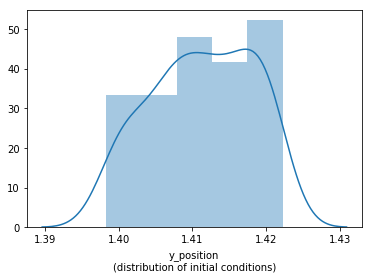

In [8]:
# Select the first state and plot its distribution
i_state = 1
plot_distribution(i_state)

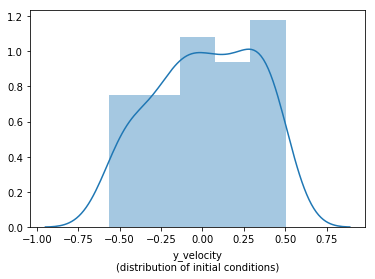

In [9]:
# Select the second state and plot its distribution
i_state = 3
plot_distribution(i_state)

### 1.5. Bivariate distribution of positions and speeds

In order to better understand the initial state distribution for Simulation Start, we now look at the 2D distribution of positions and velocities. Usually, you seek to have the initial conditions to be randomly and evenly distributed across all pairs. This ensures we are not overfitting to a specific region of the state space, having a non-robust brain on deployment state conditions that the brain did not train on.

For this test we continue looking into the initialization values WITHOUT scenario randomization.

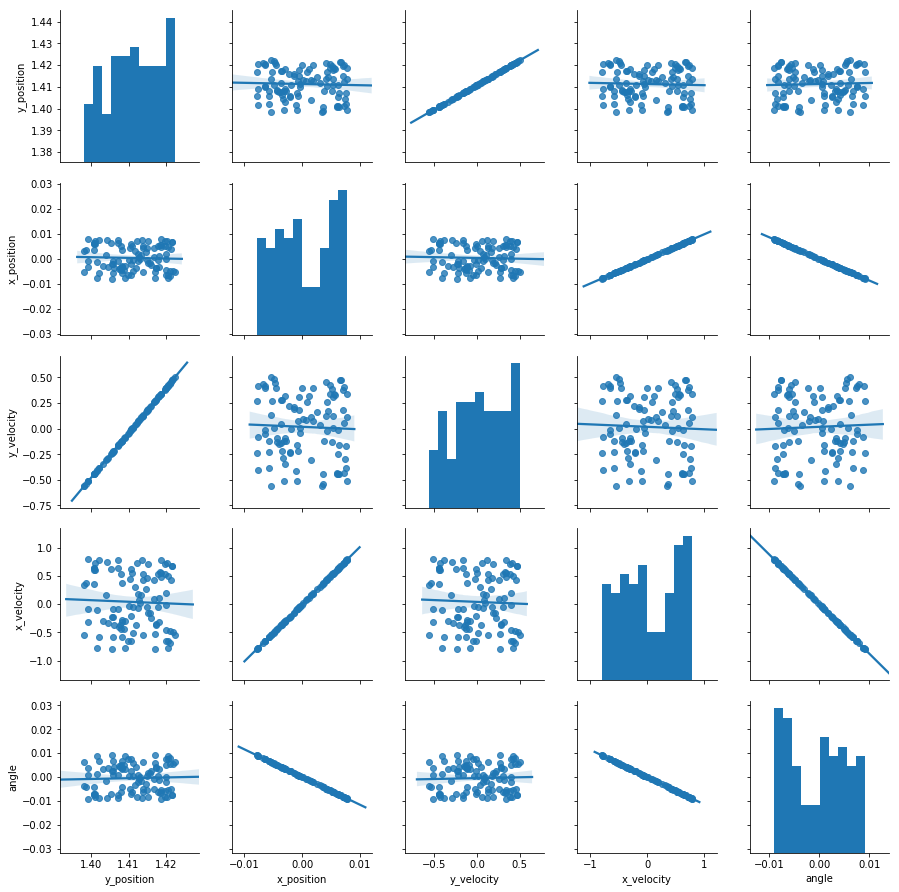

In [10]:
# Create a DataFrame from dictionary, and plot the relationship across variables.
state_df = pd.DataFrame.from_dict(state_dict_original)
sns.pairplot(state_df, kind='reg')

## 2. TEST THE INFLUENCE OF CONFIG RANDOMIZATION ON THE SIM

Configuration variables let Machine Teachers configure the way in which the simulation processes the states, actions, and/or initial conditions. The Lunar Lander sample does not permit to identify the initial x/y/angle positions. Yet, our simulation engineers were able to add a config parameter to apply random actions at episode_start. It is our job to verify the impact of this randomization parameter ('randomized_steps').

### 2.1. Extract the initial conditions -- With randomization

We test the impact of the config parameter 'randomized_steps'. We will be applying 30 consecutive iterations of random actions prior to asking the brain for its first action. We seek having more randomized initialization values across very correlated values seen between x_velocity and x_position, as well as betweem angle and x_velocity/x_position.

In [11]:
# Add to config a parameter to randomize the beginning of episode start for X number of steps.
config["randomized_steps"] = 30

# Number of episodes to initialize for the analysis.
n_episodes = 100

# Initialize a dictionary to store all the initialization conditions of the simulation across episodes.
state_dict = defaultdict(list)

# Iterate for as many episodes as selected, and plot accordingly.
for i in range(n_episodes):
    state = get_random_ini_state(config)
    state_dict = create_dict_of_arrays(state, state_dict)


### 2.2. Plot the distribution of initial state conditions
In this section we will compare the original distribution of initial state conditions against the new version which applies Scenario Randomization.

In [12]:
# Auxiliary functionality
def plot_compared_distribution(i_state):
    state = list(state_keys)[i_state-1]
    state_array = state_dict[state]
    state_array_original = state_dict_original[state]
    sns.distplot(state_array, axlabel=state+dist_text, color=(.8, .4, 0)) # ORANGE FOR CURRENT VALUES
    sns.distplot(state_array_original, axlabel=state+dist_text, color=(0, .3, .8)) # BLUE FOR ORIGINAL VALUES

    print("- ORANGE represents the values WITH Scenario Randomization for Episode Start.")
    print("- BLUE represents the original values WITHOUT Scenario Randomization.")

- ORANGE represents the values WITH Scenario Randomization for Episode Start.
- BLUE represents the original values WITHOUT Scenario Randomization.


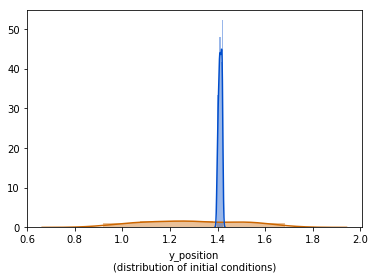

In [13]:
# Select the first state and plot its distribution.
i_state = 1
plot_compared_distribution(i_state)

- ORANGE represents the values WITH Scenario Randomization for Episode Start.
- BLUE represents the original values WITHOUT Scenario Randomization.


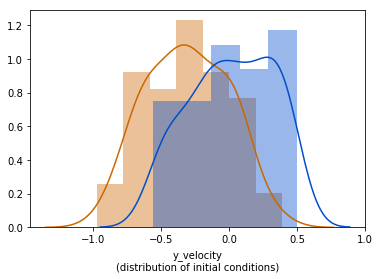

In [14]:
# Select the third state and plot its distribution.
i_state = 3
plot_compared_distribution(i_state)

### 2.3. Bivariate distribution of positions and speeds

In order to better understand the initial distribution for Simulation Start, we now look at the joint distribution of positions and velocities. We need to ensure that we are not overlooking any specific area of the state space, so that the brain is exposed to the full state. Ideally, we would like to see that the config parameter 'randomized_steps' is effectively incrementing the initial state space that the brain is exposed to for its initial action.

For this test we use the initializations WITH scenario randomization.

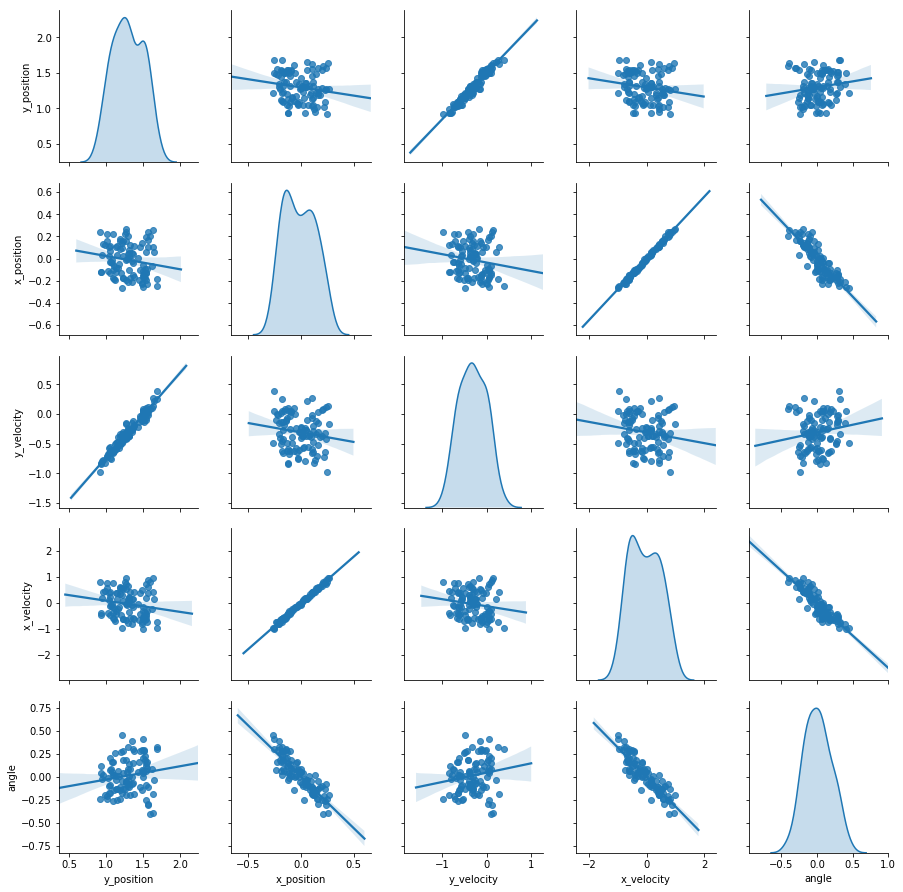

In [15]:
# Create a DataFrame from dictionary, and plot the relationship across variables.
state_df = pd.DataFrame.from_dict(state_dict)
sns.pairplot(state_df, kind='reg', diag_kind='kde')

## 3. EVALUATING CONTROL POLICIES

One important step to verify the simulation is behaving as expecting is looking at the response of the simulation to a hard-coded control. The simulation should transition as expected. Does your simulation effectively place the needed constraints? For Lunar Lander, we surely want to validate the termination flag gets raised when reaching the floor at high-speeds.

Each simulation is different. Review the results of a hard-coded control with Subject Matter Experts (SMEs) to ensure the simulation behaves as expected.

### 3.1. Retrieve all available policies

In [16]:
# Extract and print all available policies from the policies.py file.
from policies import available_policy_list

print("Available set of predefined policies:\n", available_policy_list)

Available set of predefined policies:
 ['move_right', 'move_left', 'move_up', 'move_down', 'do_nothing']


### 3.2. Define target actions & states

From all the states available we want to look into the following:
- The horizontal evolution of the spaceship using 'state_x_position' and 'state_x_velocity'
- The vertical evolution of the spaceship using 'state_y_position' and 'state_y_velocity'
- The terminal condition that indicates the ship has crashed: 'state_gym_terminal'

The actions for the Lunar Lander simulation consist on the following:
- 'engine1', (-1, 1): Main engine, which allows the ship to move up and down  ---  Valid value ranges: (-1, 1)
- 'engine2', (-1, 1): Lateral engines, which allows the ship to move laterally
  - -1 thrusts the right engine (to move to the left), 
  - +1 thrusts the left engine (to move to the right).

In [17]:
# DEFINE TARGET ACTIONS & STATES
actions_df = ["action_engine1",
              "action_engine2"]
states_df = ["state_x_position",
             "state_x_velocity",
             "state_y_position",
             "state_y_velocity",
             "state_gym_terminal",
             "state_angle"]

### 3.3. Run all available policies

Now, we run the sim with all the policies and save the resulting episodes in the 'dataframes_dict' object.

In [18]:
# Use a dictionary to store the data from each policy evaluated (in Pandas DataFrame format)
dataframes_dict = {}

# Iterate over all available policies. 
for policy_n in available_policy_list:
    
    # Run a policy into the simulation.
    print("\nPOLICY BEING TESTED:", sim.log_full_path)
    sim = test_policy(
        render=False,
        log_iterations=True,
        policy=policy_n,
        debug=False,
    )

    # Extract the logs based on the policy that we just run.
    print("\nREADING DATA FROM LOG FILE:", sim.log_full_path)
    df = pd.read_csv(sim.log_full_path)
    # Tranform gym terminal to identify crashes into a number for later plotting.
    df["state_gym_terminal"] = df["state_gym_terminal"].apply(lambda x: 1 if x else 0)

    # Extract the nummber of episodes & iterations for current run.
    n_episodes = len(df["episode"].unique())
    n_iterations = len(df["iteration"].unique())
    print("Dataset contains:", n_episodes, "total episode(s), with a max length of", n_iterations, "iteration(s).")

    # Store the dataframe into a dictionary.
    #  - The keys are the policy name, and the values are the corresponding Pandas dataframe -
    dataframes_dict[policy_n] = copy.deepcopy(df)



POLICY BEING TESTED: logs\2022-07-26-14-05-15_random_log.csv
Log filename: logs\2022-07-26-14-05-25_move_right_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-25_move_right_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs

READING DATA FROM LOG FILE: logs\2022-07-26-14-05-25_move_right_log.csv
Dataset contains: 1 total episode(s), with a max length of 71 iteration(s).

POLICY BEING TESTED: logs\2022-07-26-14-05-25_move_right_log.csv
Log filename: logs\2022-07-26-14-05-26_move_left_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-26_move_left_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs

READING DATA FROM LOG FILE: logs\2022-07-26-14-05-26_move_left_log.c

### 3.4. Plot the episodes for each policy

Now, we are ready to plot all the policies one at a time. First the evolution of the action, and then the evolution of states.

For each policy, verify the following:
- Validate the actions represent different policies,
- Validate the evolution of states correspond to what you expected for the applied actions,
- Validate the terminal conditions are hit as expected.


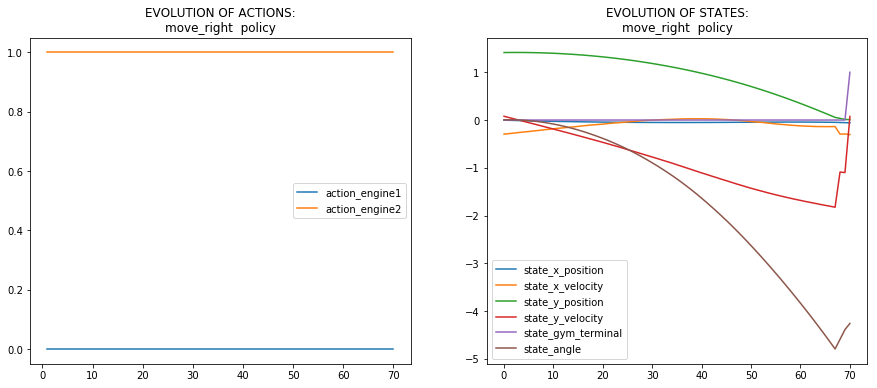

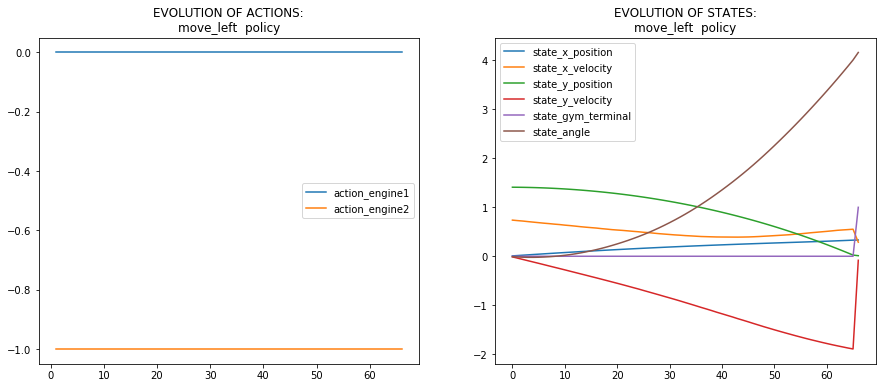

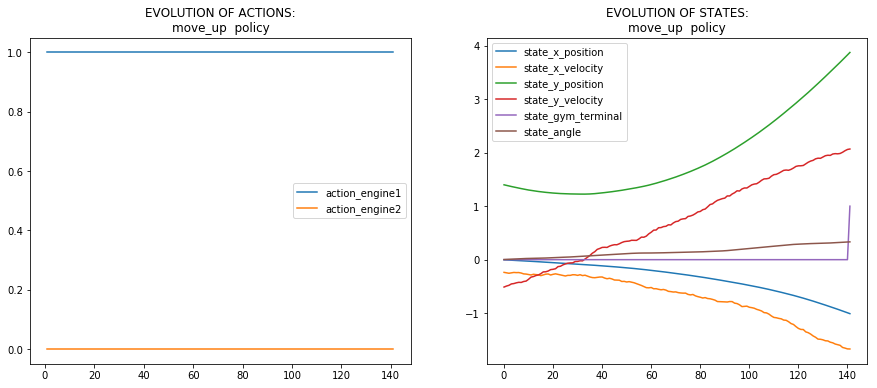

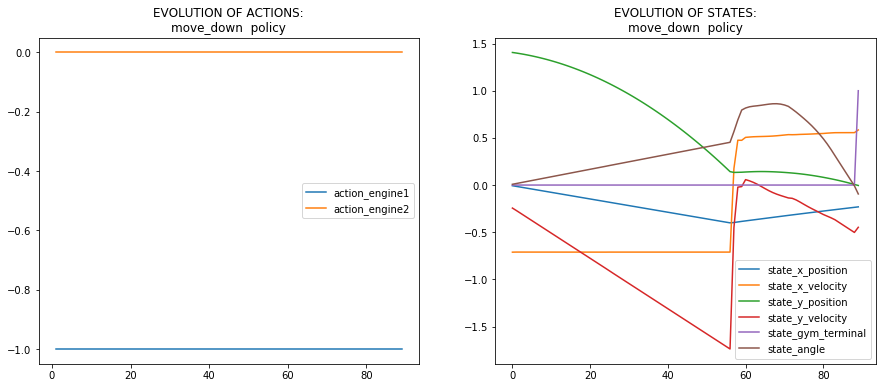

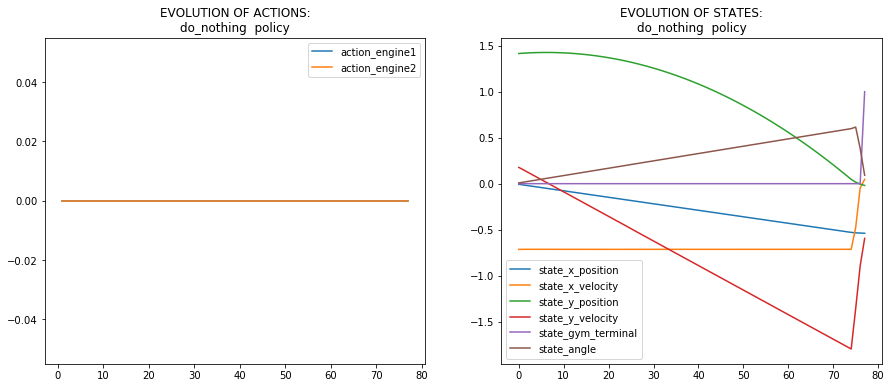

In [19]:
# Define values of interest to be extracted
actions_df = ["action_engine1",
              "action_engine2"]
states_df = ["state_x_position",
             "state_x_velocity",
             "state_y_position",
             "state_y_velocity",
             "state_gym_terminal",
             "state_angle"]

# Iterate over all policies tested to evaluate the performance.
for policy_n, policy_df in dataframes_dict.items():

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    
    # Select and plot the ACTIONS that have been extracted for current policy.
    df_reduced = policy_df[actions_df]
    df_reduced.plot(title=f"EVOLUTION OF ACTIONS:\n{policy_n}  policy", ax = axes[0]) #, subplots=True) 
    
    # Select and plot the STATES that have been extracted for current policy.
    df_reduced = policy_df[states_df]
    df_reduced.plot(title=f"EVOLUTION OF STATES:\n{policy_n}  policy", ax = axes[1]) #, subplots=True)
    
    plt.show()

## 4. EVALUATE SIMULATION SPEED

### 4.1. Extract auxiliary packages

In [20]:
# Get auxiliary objects to evaluate the time for episode start and episode step methods independently.
from sim.LunarLander import LunarLander

# Import time library to evaluate simulation speed.
import time

### 4.2. Run several tests to evaluate average execution time

In [21]:
n_tests = 400

## ----- SIM INITIALIZATION: TIME EVALUATION -----
time_array = []
for i in range(n_tests):
        # Initialize timer.
        ini_time = time.time()
        # Create a new simulation object.
        sim = LunarLander(
                render=False,
                log_data=False  # Disable saving data to prevent long waiting times
        )
        # Store time elapsed on an array.
        time_diff = time.time() - ini_time
        time_array.append(time_diff)
sim_init_mean_time = np.round(np.mean(time_array), decimals=5)
sim_init_std_time = np.round(np.std(time_array), decimals=5)


## ----- EPISODE RESET: TIME EVALUATION -----
time_array = []
for i in range(n_tests):
        # Initialize time.
        ini_time = time.time()
        # Reset a new episode for the already created simulation object.
        config = {"randomized_steps": 30}
        sim.episode_start(config)
        # Store time elapsed on an array.
        time_diff = time.time() - ini_time
        time_array.append(time_diff)
reset_mean_time = np.round(np.mean(time_array), decimals=5)
reset_std_time = np.round(np.std(time_array), decimals=5)


## ----- EPISODE STEP: TIME EVALUATION -----
time_array = []
terminal_array = []
for i in range(n_tests):
        # Initialize time.
        ini_time = time.time()
        # Reset episode if it has reached terminal conditions.
        if sim.terminal:
                # Reset a new episode for the already created simulation object.
                config = {"randomized_steps": 30}
                sim.episode_start(config)
        # Step one iteration forward with a random action.
        action = {"engine1": 2*(np.random.random()-0.5),
                  "engine2": 2*(np.random.random()-0.5)}
        sim.episode_step(action)
        # Store time elapsed on a dictionary.
        time_diff = time.time() - ini_time
        time_array.append(time_diff)
step_mean_time = np.round(np.mean(time_array), decimals=5)
step_std_time = np.round(np.std(time_array), decimals=5)

Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api

Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api

Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api-main\microsoft-bonsai-api-main\Python\samples\gym-lunarlander\logs
Log filename: logs\2022-07-26-14-05-29_LunarLanderContinuous-v2_log.csv
Log directory: C:\microsoft-bonsai-api

Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration 

Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration 

Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration for Episode Start: {'randomized_steps': 30}
Configuration 

### 4.3. Compute the average training time
Using the times evaluated above, we compute the average simulation speed to run an iteration. With that value we can compute the average time to run a full experiment with Bonsai (usually ~1 million iterations). We then output those two variables, alongn with the per-method times computed.

In [22]:
# Time to run a full experiment. Usually ~1 million iterations.
# - We consider that several sims are used in parallel to train a brain.
experiment_length = 1000000
# TODO: Increment the number of parallel simulations up to a 100 if needed to estimate a reduced training time.
n_parallel_sims = 10

# Episode length.
episode_iteration_limit = 200 # number of iterations per episode


# Compute full episode expected mean & std dev times.
full_episode_mean_time = reset_mean_time + step_mean_time*episode_iteration_limit
full_episode_std_time = reset_std_time + step_std_time*episode_iteration_limit

# Compute average per iteration length.
# - We account for the mean time spent on the communication between sim and brain.
# -- This time includes the inference and update of the neural network.
Bonsai_brain_to_sim_communication_time = .045  # seconds per iteration per node
per_iteration_mean_time = full_episode_mean_time/episode_iteration_limit + Bonsai_brain_to_sim_communication_time
per_iteration_std_time = full_episode_std_time/episode_iteration_limit

# Time to run a full experiment.
experimentation_time = per_iteration_mean_time*experiment_length/n_parallel_sims

# Format the data before printing:
# - Format experiment length to be readable.
# - Round new computed time values.
experiment_length_str = "{:,}".format(experiment_length)
per_iteration_mean_time = np.round(per_iteration_mean_time, decimals = 5)
per_iteration_std_time = np.round(per_iteration_std_time, decimals = 5)
experimentation_time_h = np.round(experimentation_time/60/60, decimals=3)

# Print all the information extracted.
print(f"The simulation speed per iteration is {per_iteration_mean_time} s  +- {per_iteration_std_time} s.")
print(f"\nAt that rate, an experiment of {experiment_length_str} iterations will take ~{experimentation_time_h} hour(s).")
print(f"- Note, we are assuming {n_parallel_sims} sims are running in parallel.")
print("\nDetailed simulation specs:")
print(f"- Average time elapsed for sim initialization:  {sim_init_mean_time} s  +- {sim_init_std_time} s.")
print(f"- Average time elapsed for episode reset:  {reset_mean_time} s  +- {reset_std_time} s.")
print(f"- Average time elapsed for episode step:  {step_mean_time} s  +- {step_std_time} s.")
print(f"- Communication time between sim & Bonsai: ~ {Bonsai_brain_to_sim_communication_time} s.")

The simulation speed per iteration is 0.04544 s  +- 0.00093 s.

At that rate, an experiment of 1,000,000 iterations will take ~1.262 hour(s).
- Note, we are assuming 10 sims are running in parallel.

Detailed simulation specs:
- Average time elapsed for sim initialization:  0.00137 s  +- 0.00055 s.
- Average time elapsed for episode reset:  0.00851 s  +- 0.00152 s.
- Average time elapsed for episode step:  0.0004 s  +- 0.00092 s.
- Communication time between sim & Bonsai: ~ 0.045 s.


# SUMMARY

This notebook focused on the following 4 tests:

1. **Test Initialization Conditions**: The initial conditions across episodes are expected and valid for our training.
2. **Test Config Parameters**: The configuration parameters work as expected.
3. **Test Simulation Behavior**: The response of the simulation to programmed actions iterates as expected.
4. **Test Simulation Speed**: Simulation speed must be faster than 0.1 s/it.

Additional tests that happen before or after the ones displayed in this notebook:
- Verify Bonsai Training Compatibility: The model must have STEP, START, RESET, STATE functionality.
- Test Baseline Control: Evaluate the performance of an expert policy, as well as a simple hard-coded policy (even if non-effective), is useful to benchmark the target KPI value the brain must overperform.

For further considerations, feel free to look at the following guide:
- [The Bonsai Cookbook: Recipe 13 The Sim-to-Real Gap and How to Address It](https://orange-desert-095eaeb1e.azurestaticapps.net/the-sim-to-real-gap-and-how-to-address-it.html)